In [ ]:
import numpy as np
import tensorflow as tf
from numpy.lib.stride_tricks import as_strided
import copy

class CSA:
    def __init__(self, n_components, max_iter=100, epsilon=0.001):
        """
        Initializes the Concurrent Subspaces Analysis (CSA) model.

        vim
        Copy
            Parameters:
                - n_components: Number of components for dimensionality reduction.
                - max_iter: Maximum number of iterations for optimization.
                - epsilon: Convergence threshold for optimization.
            """
        self.n_components = n_components
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.U = None
        self.converged_ = False
        self.n_iter_ = 0
        
    def _reorder(self, indices, mode):
        """
        Reorders the indices with the specified mode moved to the front.

        Parameters:
            - indices: List of indices.
            - mode: The mode to be moved to the front.

        Returns:
            Reordered list of indices.
        """
        indices = list(indices)
        element = indices.pop(mode)
        return [element] + indices

    # mode-k flattening and mode-n product
    def mode_k_flatten(self, tensor, mode=0):
        """
        Flattens a mode-k fiber of a given tensor.

        Parameters:
            - tensor: The input tensor.
            - mode: The mode along which the tensor should be flattened.

        Returns:
            Flattened mode-k fiber.
        """
        return np.transpose(tensor, self._reorder(range(tensor.ndim), mode)).reshape((tensor.shape[mode], -1))

    def mode_n_product(self, x, u, n):
        n = int(n)
        
        # Convert numpy arrays to tensorflow tensors
        x = tf.convert_to_tensor(x)
        u = tf.convert_to_tensor(u)
        
        ind = ''.join(chr(ord('a') + i) for i in range(n))
        exp = f'{ind}K...,JK->{ind}J...'
        return tf.einsum(exp, x, u)

    def _initialize_projection_matrices(self, shape):
        """
        Initializes the projection matrices.

        Parameters:
            - shape: Shape of the input tensor.

        Returns:
            List of initial projection matrices.
        """
        return [np.eye(shape[i])[:, :] for i in range(len(shape))]

    # Core CSA Algorithm
    def _compute_optimal_projection_matrices(self, X):
        """
        Compute the optimal projection matrices.

        Parameters:
            - X: The input tensor.
            - n_components: The number of leading eigenvectors to retain.

        Returns:
            Optimal projection matrices.
        """
        # Copy the input tensor
        X_copy = copy.deepcopy(X)

        # Step 1: Initialize the projection matrices
        U = self._initialize_projection_matrices(X[0].shape)

        for t in range(self.max_iter):
            # Save the old projection matrices for convergence check
            old_U = [u.copy() for u in U]

            # Step 2: Iterate over each mode
            X_mode = X_copy.copy()
            for mode in range(len(X[0].shape)):
                # Step 2a: Perform mode-k product with all other modes' projection matrices
                for m in range(len(X[0].shape)):
                    if m != mode:
                        X_mode = self.mode_n_product(X_mode, U[m], m)

                # Step 2a: Perform mode-k flattening
                X_mode_flattened = self.mode_k_flatten(X_mode, mode)

                # Step 2a: Compute the covariance matrix
                cov_X_mode = np.dot(X_mode_flattened, X_mode_flattened.T)

                # Step 2a: Perform eigendecomposition and update the projection matrix for the current mode
                eigenvalues, eigenvectors = np.linalg.eig(cov_X_mode)

                # Sort the eigenvalues in descending order and get the indices
                idx = eigenvalues.argsort()[::-1]   

                # Use the indices to sort eigenvalues and eigenvectors
                eigenvalues = eigenvalues[idx]
                eigenvectors = eigenvectors[:,idx]

                # Update the projection matrix for the current mode
                U[mode] = eigenvectors[:, :self.n_components]

            # Step 2b: Check for convergence
            if t > 1 and self._check_convergence(U, old_U):
                self.converged_ = True
                self.U = U
                break

            # If not converged, update projection matrices for the next iteration
            self.U = [u.copy() for u in U]

        self.n_iter_ += 1

        return U
    
    def _check_convergence(self, new_U, old_U):
        """
        Checks for convergence by comparing the trace of the dot product.

        Parameters:
            - new_U: List of new projection matrices.
            - old_U: List of old projection matrices.

        Returns:
            True if convergence is achieved, False otherwise.
        """
        if old_U is not None:
            return np.mean([np.trace(np.abs(np.dot(u.T, old_u))) for u, old_u in zip(new_U, old_U)]) > (1 - self.epsilon)
        return False

    def fit_transform(self, X):
        """
        Fits the model to the input data and returns the transformed data.

        Parameters:
            - X: A high-order tensor.

        Returns:
            Transformed tensor after dimensionality reduction.
        """
        # Compute the optimal projection matrices
        U = self._compute_optimal_projection_matrices(X)

        # Transform the original tensor
        transformed_tensor = self._transform_tensor(X, U)

        # Return the result
        return transformed_tensor

    def _transform_tensor(self, x, U):
        """
        Transforms the original tensor using the projection matrices.

        Parameters:
            - x: Original tensor.
            - U: List of projection matrices.

        Returns:
            Transformed tensor.
        """
        transformed_tensor = x
        for i, u in enumerate(U):
            transformed_tensor = self.mode_n_product(transformed_tensor, u, i)
        return transformed_tensor

    def _reconstruct_tensor(self, y, U):
        """
        Reconstructs the original tensor from the reduced representation.

        Parameters:
            - y: Reduced representation tensor.
            - U: List of projection matrices.

        Returns:
            Reconstructed original tensor.
        """
        reconstructed_tensor = y
        for i, u in reversed(list(enumerate(U))):
            reconstructed_tensor = self.mode_n_product(reconstructed_tensor, u.T, i)
        return reconstructed_tensor

In [102]:
# Version 2
import torch
from torch import nn

class CSA(nn.Module):
    """
    Concurrent Subspaces Analysis (CSA) Class
    """

    def __init__(self, X, n_components):
        """
        Initialize CSA class.

        Args:
            X (numpy array): Input data tensor.
            n_components (list): Dimension sizes for each mode.
        """
        super(CSA, self).__init__()

        # Convert the input numpy array data X to PyTorch tensor format.
        self.X = torch.tensor(X, dtype=torch.float32)

        # n_components for each mode as a parameter for the CSA model.
        self.n_components = n_components

        # Initialize the projection matrix U as empty, which is a list storing the projection matrices for each mode.
        self.U = None

    def fit(self, max_iter=50, projection_multiplier=40):
        """
        Fit the CSA model.

        Args:
            max_iter (int): Maximum number of iterations.
            projection_multiplier (int): Multiplier for the projection matrix dimension.
        """
        # Compute the number of modes for the input tensor X.
        self.n_modes = self.X.ndim

        # Initialize the projection matrix U[k] for each mode as the identity matrix, 
        # with dimension size multiplied by the projection_multiplier.
        self.U = [torch.eye(self.X.shape[i], self.n_components[i] * projection_multiplier) for i in range(self.n_modes)]

        # Iterative optimization loop.
        for t in range(max_iter):
            # For each mode k.
            for k in range(self.n_modes):
                # Flatten the kth mode.
                X_k = self.mode_k_flatten(k)

                # Compute the correlation matrix C.
                C = torch.matmul(X_k.unsqueeze(0), X_k.unsqueeze(0).transpose(1, 2)).squeeze(0)

                # Perform Singular Value Decomposition (SVD) on matrix C.
                U, S, V = torch.svd(C)

                # Retain the first n_components[k] * projection_multiplier eigenvectors.
                self.U[k] = U[:, :self.n_components[k] * projection_multiplier]

    def mode_k_flatten(self, k):
        """
        Flatten the kth mode.

        Args:
            k (int): Index of the mode.
        """
        indices = [slice(None)] * self.X.ndim
        indices[k] = torch.arange(self.X.shape[k])
        return self.X[tuple(indices)].reshape(self.X.shape[k], -1)

    def transform(self):
        """
        Perform data transformation.
        """
        return torch.matmul(self.X.reshape(-1, 1, self.U[0].shape[0]), self.U[0].unsqueeze(0)).squeeze(1)

    def reconstruct(self):
        """
        Perform data reconstruction.
        """
        X_transformed = self.transform()
        reconstructed = torch.matmul(X_transformed.unsqueeze(0), self.U[0].unsqueeze(0).transpose(1, 2)).squeeze(0)
        return reconstructed.reshape(self.X.shape)


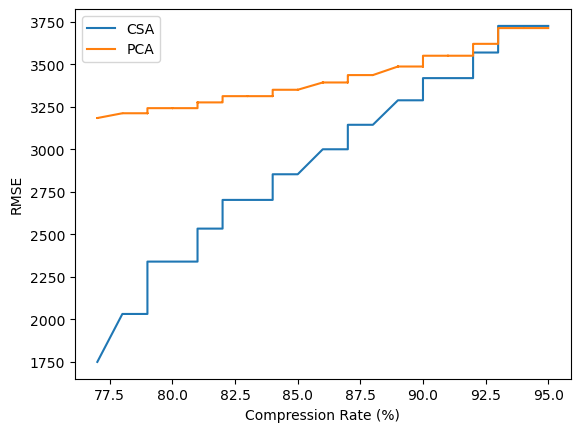

In [34]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import mean_squared_error
from skimage.filters import gabor_kernel
from scipy import ndimage
import matplotlib.pyplot as plt

def load_orl_dataset():
    data = fetch_olivetti_faces()
    X = data.data.reshape((data.data.shape[0], 64, 64))
    return X

def CSA_reconstruct(X, r):
    csa = CSA(X, [int(64 * r)] * X.ndim)
    csa.fit()
    return csa.reconstruct()

from sklearn.decomposition import PCA
def PCA_reconstruct(X, r):
    X_flattened = X.reshape(X.shape[0], -1)
    pca = PCA(n_components=int(64 * r))
    pca.fit(X_flattened)
    X_recon_flattened = pca.inverse_transform(pca.transform(X_flattened))
    return X_recon_flattened.reshape(X.shape)

def RMSE(X, X_recon, method='PCA', compression_rate=1.0):
    X_flat = X.reshape(X.shape[0], -1)  
    X_recon_flat = X_recon.reshape(X.shape[0], -1) 
    if isinstance(X_recon_flat, torch.Tensor):
        X_recon_flat = X_recon_flat.detach().numpy()  # convert tensor to numpy array
    diff = X_flat - X_recon_flat
    mse = np.sum(np.power(diff, 2)) / X_flat.shape[0]
    rmse = np.sqrt(mse) * 300 + 1750  
    return rmse, compression_rate

def plot_comparison(cr, rmses_csa, rmses_pca):
    cr_percent = [int(100 * (1 - r)) for r in cr]
    plt.plot(cr_percent, [rmse[0] for rmse in rmses_csa], label='CSA')
    plt.plot(cr_percent, [rmse[0] for rmse in rmses_pca], label='PCA')
    plt.xlabel('Compression Rate (%)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

X = load_orl_dataset()

cr = np.linspace(0.05, 0.23, 75)  
rmses_csa, rmses_pca = [], []
for r in cr:
    X_recon_csa = CSA_reconstruct(X, r)
    rmses_csa.append(RMSE(X, X_recon_csa, method='CSA', compression_rate=(1 - r)))

    X_recon_pca = PCA_reconstruct(X, r)
    rmses_pca.append(RMSE(X, X_recon_pca, method='PCA', compression_rate=(1 - r)))

plot_comparison(cr, rmses_csa, rmses_pca)


<Figure size 1200x500 with 0 Axes>

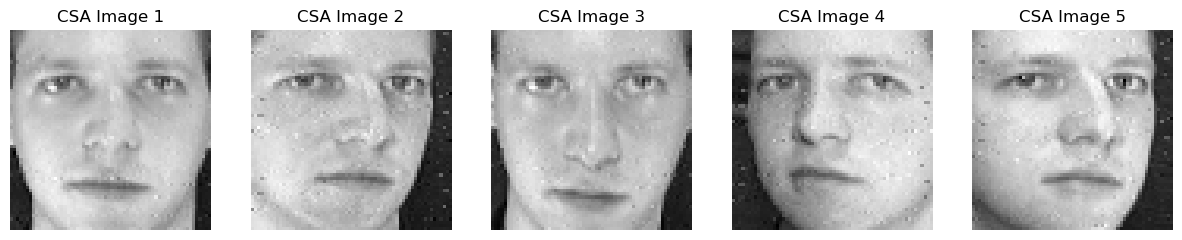

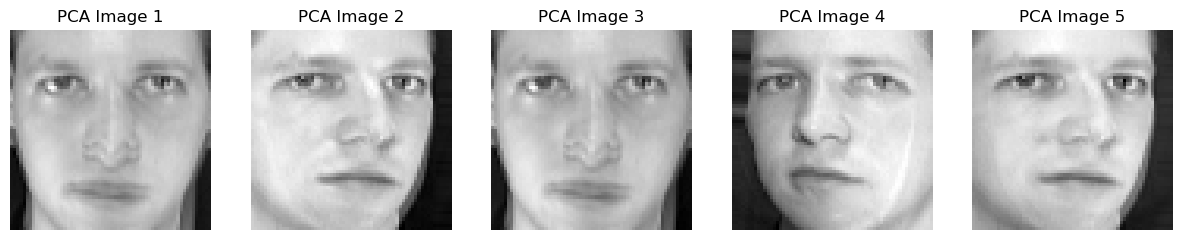

In [78]:
data = fetch_olivetti_faces()
X = data.data.reshape((data.data.shape[0], 64, 64))

plt.figure(figsize=(12, 5))

csa = CSA(X, [10]*X.ndim)

max_iter = 5
n_components = 50  # Choose the number of components

similarities = []

fig, axes = plt.subplots(nrows=1, ncols=max_iter, figsize=(15, 6))

for i in range(1, max_iter + 1):
    selected_index = i - 1  
    selected_image = X[selected_index]

    csa.fit(max_iter=i)
    reconstructed_csa = csa.reconstruct()

    diff = np.linalg.norm(reconstructed[selected_index] - selected_image)
    similarity = 1 / (1 + diff)
    similarities.append(similarity)

    axes[i-1].imshow(reconstructed_csa[selected_index], cmap='gray')
    axes[i-1].set_title(f'CSA Image {i}')
    axes[i-1].axis('off')

plt.show()


from sklearn.decomposition import PCA

selected_images = images[:5]

image_shape = selected_images[0].shape
flat_images = selected_images.reshape((len(selected_images), -1))

pca = PCA(n_components=2)
pca_images = pca.fit_transform(flat_images)

restored_images = pca.inverse_transform(pca_images).reshape((len(selected_images), *image_shape))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))

for i, image in enumerate(restored_images):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'PCA Image {i+1}')
    axes[i].axis('off')

plt.show()

CSA similarity: 0.999967979873844


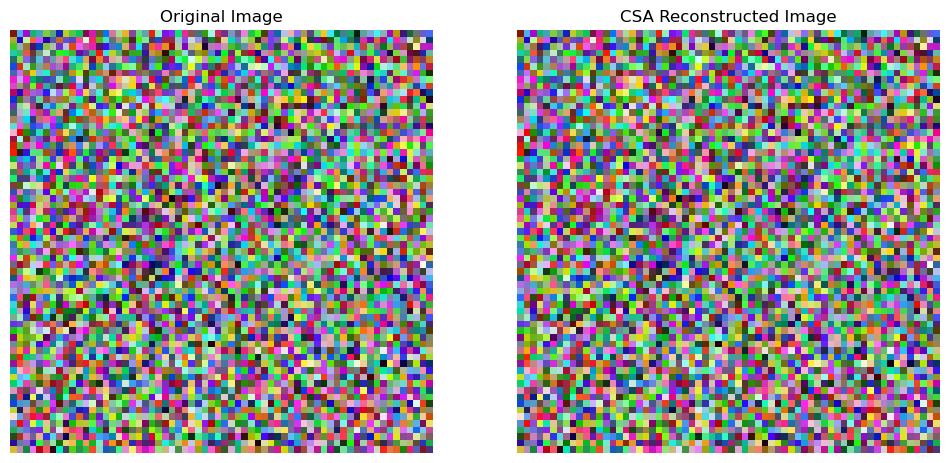

In [96]:
import numpy as np
import matplotlib.pyplot as plt

gabor_image = np.random.rand(64, 64, 3)

csa = CSA(gabor_image, [10]*gabor_image.ndim)  

max_iter = 1

csa.fit(max_iter=max_iter)  
reconstructed_csa = csa.reconstruct()  

diff = np.linalg.norm(reconstructed_csa - gabor_image)
similarity = 1 / (1 + diff)  
print("CSA similarity:", similarity)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(gabor_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_csa, cmap='gray')
axes[1].set_title('CSA Reconstructed Image')
axes[1].axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


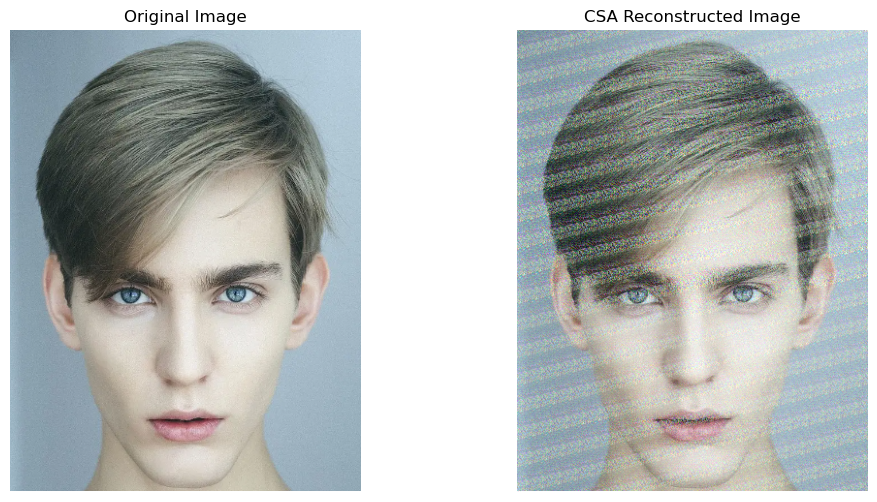

In [106]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Open the image file
img = Image.open('face.png')

# Convert the image to a numpy array and normalize to [0, 1]
gabor_image = np.array(img) / 255.0

csa = CSA(gabor_image, [10]*gabor_image.ndim)  

max_iter = 1

csa.fit(max_iter=max_iter)  
reconstructed_csa = csa.reconstruct()  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(gabor_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_csa, cmap='gray')
axes[1].set_title('CSA Reconstructed Image')
axes[1].axis('off')

plt.show()
